## Binary classification for prediction of the compound activity with respect to adenosine A2a receptor

### Almaz Gilmullin 760235219, Anastasiia Krokhina 659711595

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
target = 'aa2ar'
url = f'https://dude.docking.org//targets/{target}'

In [3]:
active = pd.read_csv(f'{url}/actives_combined.ism', header=None, sep=' ', on_bad_lines='skip')
inactive = pd.read_csv(f'{url}/inactives_combined.ism', header=None, sep=' ', on_bad_lines='skip')

decoys = pd.read_csv(f'{url}/decoys_final.ism', header=None, sep=' ', on_bad_lines='skip')

In [4]:
active = pd.DataFrame({'smiles':active[0], 'label': [1]*len(active[0])})
active_size = active.shape[0]
active_size

3050

In [5]:
inactive = pd.DataFrame({'smiles': inactive[0], 'label': [0]*len(inactive[0])})
inactive_size = inactive.shape[0]
inactive_size

192

In [6]:
decoys = pd.DataFrame({'smiles':decoys[0], 'label': [0]*len(decoys[0])})
decoys_size = decoys.shape[0]
decoys_size

31550

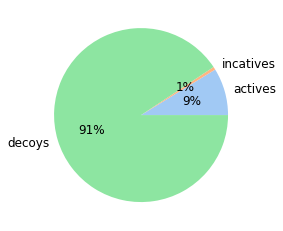

In [34]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

data = [active_size, inactive_size, decoys_size]
labels = ['actives', 'incatives', 'decoys']
#create pie chart
plt.pie(data, labels=labels, colors = colors, autopct='%.0f%%', textprops={"fontsize":12})
plt.show()
# plt.savefig('./aaa.png')

In [41]:
# Our way to deal with imbalance - Combine inactives and decoys

size = active.shape[0] - inactive.shape[0]
split_decoys = decoys[:size]

In [8]:
data = pd.concat([active, inactive, decoys], ignore_index=True)
data

,smiles,label
0,c1cc2c(c(c1)Br)c(c[nH]2)CCOc3nc(c4c(n3)n(cn4)[...,1
1,c1cc2c(cc1Br)c(c[nH]2)CCOc3nc(c4c(n3)n(cn4)[C@...,1
2,c1cc2c(cc1Br)[nH]cc2CCOc3nc(c4c(n3)n(cn4)[C@H]...,1
3,c1cc2c(cc1CCNc3nc(c4c(n3)n(cn4)C5[C@@H]([C@@H]...,1
4,c1cc2c(cc1Cl)-c3c(c(nc(n3)N)c4ccc(o4)Br)C2,1
...,...,...
34787,Cc1ccc(cc1)NS(=O)(=O)c2cc(ccc2OC)C(=O)O[C@@H](...,0
34788,Cc1cc(nc(n1)N/C(=N\C(=S)NC[C@H]2CCCO2)/N3CCN(C...,0
34789,C[C@H](C(=O)Nc1ccc(c(c1)[N+](=O)[O-])F)OC(=O)C...,0
34790,COC(=O)[C@@]1(C[C@@H]([C@@H]([C@@H](O1)COP(=O)...,0


### Feature generation - RDKit Library

In [9]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator as MDC

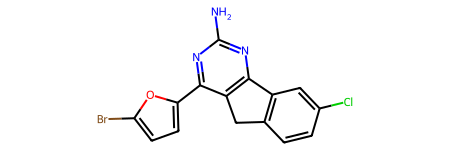

In [10]:
mol = Chem.MolFromSmiles(data.smiles[4])
mol

In [11]:

def RDkit_descriptors(data):
    mols = [Chem.MolFromSmiles(i) for i in data.smiles]
    desc_names = list(CalcMolDescriptors(mols[0]).keys())
    desc_names.append("label")
    mol_descs = []
    for i in tqdm(range(len(data))):
        descriptors = CalcMolDescriptors(mols[i])
        descriptors['label'] = data.label[i]
        mol_descs.append(descriptors)
    return mol_descs, desc_names

In [12]:
mol_descs,desc_names = RDkit_descriptors(data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34792/34792 [12:13<00:00, 47.46it/s]


In [14]:
new_df = pd.DataFrame(mol_descs,columns=desc_names)
new_df

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,label
0,10.337455,10.337455,0.057778,-1.272753,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,1
1,10.335047,10.335047,0.059736,-1.271941,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,1
2,10.333078,10.333078,0.061184,-1.271281,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,1
3,10.355554,10.355554,0.205346,-1.235039,0.369988,25.218750,440.504,412.280,440.217203,170,...,0,0,0,0,0,0,0,0,0,1
4,6.090409,6.090409,0.226017,0.226017,0.547921,12.285714,362.614,353.542,360.961752,104,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34787,12.933117,12.933117,0.026874,-4.100987,0.602223,14.468750,461.496,438.312,461.125671,170,...,1,0,0,0,0,0,0,0,1,0
34788,5.666491,5.666491,0.191419,0.191419,0.400631,19.187500,455.592,426.360,455.221578,170,...,0,0,0,0,0,0,0,0,0,0
34789,13.336315,13.336315,0.076157,-3.927724,0.337664,12.322581,451.432,433.288,451.084949,164,...,1,0,0,0,0,0,0,0,0,0
34790,13.414551,13.414551,0.220101,-4.286701,0.417596,25.687500,468.395,443.195,468.118534,174,...,0,0,0,0,0,0,0,0,0,0


In [15]:
new_df.to_csv('all_desc.csv',index=False)

In [116]:
## Can start from here
new_df = pd.read_csv('desc.csv')

In [117]:
X = new_df.iloc[:,:-1]
y = data.label
X

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.337455,10.337455,0.057778,-1.272753,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,0
1,10.335047,10.335047,0.059736,-1.271941,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,0
2,10.333078,10.333078,0.061184,-1.271281,0.255933,23.375000,505.329,484.161,504.075680,168,...,0,0,0,0,0,0,0,0,0,0
3,10.355554,10.355554,0.205346,-1.235039,0.369988,25.218750,440.504,412.280,440.217203,170,...,0,0,0,0,0,0,0,0,0,0
4,6.090409,6.090409,0.226017,0.226017,0.547921,12.285714,362.614,353.542,360.961752,104,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,12.319151,12.319151,0.017230,-3.862462,0.430330,16.000000,404.404,388.276,404.079055,146,...,0,1,0,0,0,0,0,0,0,0
6096,13.479540,13.479540,0.089593,-3.870532,0.661537,30.133333,433.490,410.306,433.141990,160,...,0,0,0,0,0,0,0,0,0,1
6097,13.479540,13.479540,0.089593,-3.870532,0.661537,30.133333,433.490,410.306,433.141990,160,...,0,0,0,0,0,0,0,0,0,1
6098,11.109896,11.109896,0.052139,-1.484804,0.591959,33.259259,379.321,362.185,379.090331,144,...,0,0,0,0,0,0,0,0,0,0


In [118]:
X.shape

(6100, 210)

### Filtering - deleting invariant data

In [119]:
del_col = []
for col in X.columns:
    if len(X[col].unique()) == 1:
        X.drop(col, inplace=True, axis=1)
        del_col.append(col)

In [120]:
X.shape

(6100, 198)

In [49]:
del_col

['NumRadicalElectrons',
 'SMR_VSA8',
 'SlogP_VSA9',
 'fr_benzodiazepine',
 'fr_diazo',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_lactam',
 'fr_phos_acid',
 'fr_phos_ester',
 'fr_prisulfonamd',
 'fr_thiocyan']

### Deleting correlated data

In [50]:
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# to_drop = []   # If you want to know what features have been removed
# for column in upper.columns:
#     if any(upper[column] > 0.95):
#         to_drop.append(column)
#         print(column)

# Drop features 
X.drop(to_drop, axis=1, inplace=True)

In [85]:
left_columns = X.columns

In [86]:
# Scaling
from sklearn.preprocessing import StandardScaler

In [87]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Data split

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_test.value_counts()

1    327
0    283
Name: label, dtype: int64

### SVC

In [64]:
from numpy import mean
from sklearn import svm
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,f1_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance

In [68]:
svc = svm.SVC(random_state=0)

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
param_grid = {'C':[1, 10, 100],
                  'gamma':[0.01,0.001],
                 'kernel': ['rbf']}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(svc, param_grid, cv=cv, scoring=scoring, refit='AUC', verbose=1)

%time grid.fit(X_train, y_train)

print()
print(grid.best_params_)
print(grid.best_estimator_)

y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)

score = roc_auc_score(y_test, y_pred)
print("Mean ROC AUC:", score)

Fitting 30 folds for each of 6 candidates, totalling 180 fits
CPU times: user 18min 12s, sys: 12.5 s, total: 18min 24s
Wall time: 18min 25s

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.001)
Error: 0.3327868852459016
Accuracy: 0.6672131147540984
Mean ROC AUC: 0.6893647140186512


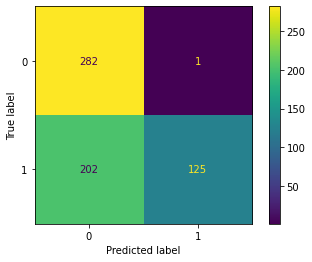

In [72]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
disp.plot()
# plt.show()
plt.savefig('conf_unscal.jpg')

In [97]:

svc = svm.SVC(C=100, gamma=0.001)

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)

score = roc_auc_score(y_test, y_pred)
print("Mean ROC AUC:", score)

Accuracy: 0.9737704918032787
Mean ROC AUC: 0.9724446461568387


### Plotting the result

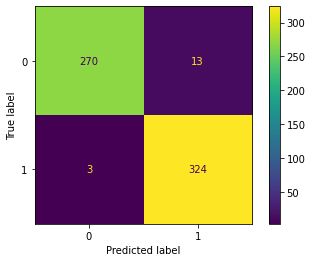

/home/almaz/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/almaz/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/almaz/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/almaz/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/almaz/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [100]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()
# plt.show()
plt.savefig('conf_scal.jpg')

#### Feature contribution

In [ ]:
# See Feature selection

Text(0.5, 0, 'Permutation Importance')

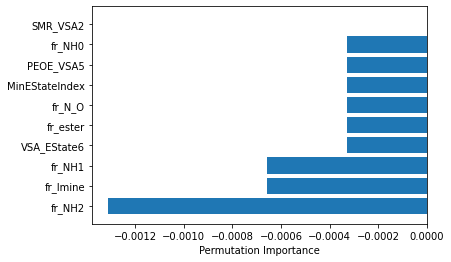

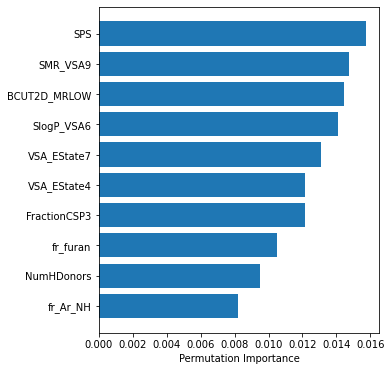

In [139]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.barh(features[sorted_idx][-10:], perm_importance.importances_mean[sorted_idx][-10:])
plt.xlabel("Permutation Importance")
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('top10_feat.png')

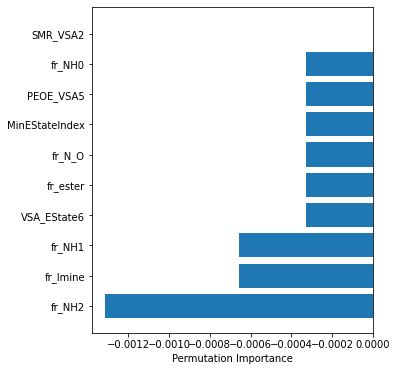

In [138]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.barh(features[sorted_idx][:10], perm_importance.importances_mean[sorted_idx][:10])
plt.xlabel("Permutation Importance")
plt.gcf().subplots_adjust(left=0.25)
plt.savefig('top-10_feat.png')

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = len(left_columns))
pca_traindata = pca.fit(X_train)

In [ ]:
pcatrain = pca_traindata.transform(X_train)
pcatest = pca_traindata.transform(X_test)
cum_ratio = (np.cumsum(pca_traindata.explained_variance_ratio_))

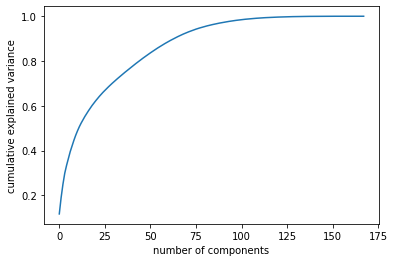

In [ ]:
# Visualize PCA result
plt.plot(np.cumsum(pca_traindata.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig('pca.png')

In [ ]:
pca = PCA(n_components = 100)
pca_traindata = pca.fit(X_train)

pcatrain = pca_traindata.transform(X_train)
pcatest = pca_traindata.transform(X_test)
(np.cumsum(pca_traindata.explained_variance_ratio_))

array([0.11730498, 0.18988867, 0.24972084, 0.29921373, 0.33437896,
       0.36559495, 0.39548848, 0.42103042, 0.44567133, 0.46835116,
       0.48837446, 0.50673748, 0.52297857, 0.53796789, 0.55199983,
       0.56495771, 0.57776042, 0.58991839, 0.60156695, 0.61254604,
       0.62272638, 0.63279768, 0.64239097, 0.65169552, 0.66046319,
       0.668771  , 0.67701851, 0.68499582, 0.69284346, 0.70029475,
       0.70765447, 0.71487444, 0.72199449, 0.72899722, 0.73596156,
       0.74276304, 0.74953321, 0.75615766, 0.76273595, 0.76928917,
       0.7758125 , 0.78227117, 0.78868828, 0.7950128 , 0.80122102,
       0.8073313 , 0.81336282, 0.81925055, 0.82512201, 0.83088303,
       0.83656016, 0.84214227, 0.8476815 , 0.85307313, 0.85837624,
       0.86349453, 0.86855312, 0.87355128, 0.87832779, 0.88305325,
       0.88760833, 0.89207452, 0.8963954 , 0.90068746, 0.90486487,
       0.90887005, 0.9128443 , 0.91665811, 0.92030616, 0.92385878,
       0.92725812, 0.93045647, 0.93355558, 0.93660085, 0.93957

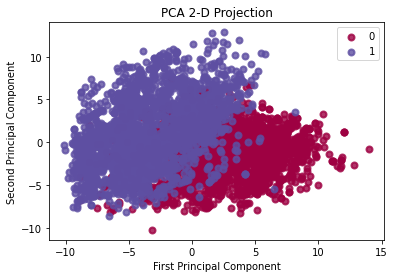

In [ ]:
import scikitplot as skplt
skplt.decomposition.plot_pca_2d_projection(pca, X_train, y_train)
plt.savefig('pc1pc2_relat.png')

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=20):
    
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()


In [ ]:
plot_coefficients(svc, left_columns)

NameError: name 'svc' is not defined

### SVC 2

In [58]:
svc = svm.SVC(C=1, gamma=0.0001)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(svc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=3)

svc = svm.SVC(C=1, gamma=0.0001)
accuracy = cross_val_score(svc, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, verbose=3)
print('Mean ROC AUC: %.3f' % mean(scores))
print('Accuracy: %.3f' % mean(accuracy))

Mean ROC AUC: 0.788
Accuracy: 0.725


## Naive Bayes

In [90]:
from sklearn.naive_bayes import GaussianNB

In [91]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_nb)

score = roc_auc_score(y_test, y_pred)
print("Mean ROC AUC:", score)

Accuracy: 0.9114754098360656
Mean ROC AUC: 0.9081596265439102


### Logistic Regression

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression

In [95]:
SEED = 42

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

lr = Pipeline([('p_trans', PowerTransformer(method='yeo-johnson', standardize=True)),
               ('lr', LogisticRegression(solver='liblinear',
                                         penalty='l1',
                                         max_iter=200,
                                         class_weight='balanced',
                                         random_state=SEED)
               )])

# lr = Pipeline([('lr', LogisticRegression(solver='liblinear',
#                                          penalty='l1',
#                                          max_iter=200,
#                                          class_weight='balanced',
#                                          random_state=SEED)
#                )])

scores = cross_val_score(estimator=lr, X=X, y=y, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)

print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

lr.fit(X_train, y_train);

scores = [0.95983607 0.95       0.96721311 0.95655738 0.96229508] 
mean score = 0.95918 +/- 0.00576


In [80]:
df_score = pd.DataFrame(data={'score': lr['lr'].coef_[0]}, index=left_columns).sort_values(by='score')
# df.plot(kind='barh', grid=True, figsize=(6,6), legend=False)

In [81]:
df_score

,score
BertzCT,-2.567480
FractionCSP3,-2.345678
SlogP_VSA6,-1.340210
NumAromaticCarbocycles,-1.314294
NumAliphaticHeterocycles,-1.288903
...,...
fr_furan,1.493800
VSA_EState2,1.786875
VSA_EState6,1.971515
SlogP_VSA2,2.194154


In [94]:
y_pred = lr.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print("Mean ROC AUC:", score)

accuracy_nb = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_nb)

Mean ROC AUC: 0.9590235679320518
Accuracy: 0.9606557377049181


#### We have high accuracy and high AUC score in classification, it's better to go to regression to better progress